### Package Installation and Environment Setup
* Install required packages
* Check PyTorch installation and CUDA availability

In [34]:
!pip install numpy torch torchvision pillow matplotlib tqdm gdown
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060 Ti



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Download and Extract CAPTCHA Images from Google Drive

In [35]:
import os
import gdown
from pathlib import Path
import zipfile
import shutil

# Create directories
os.makedirs('data', exist_ok=True)
os.makedirs('data/images', exist_ok=True)

file_id = '1Qy4geTaJqoRPuaut8V-VFQYpnQS4gTds'
output = 'data/captcha_images.zip'
CAPTCHA_DIR = 'data/images'

# Check if the directory already exists
if os.path.exists(CAPTCHA_DIR) and os.listdir(CAPTCHA_DIR):
    print(f"Directory '{CAPTCHA_DIR}' already exists and is not empty.")

else:
    print(f"Directory '{CAPTCHA_DIR}' does not exist or is empty. Proceeding with download.")
    print("Downloading CAPTCHA images from Google Drive...")
    try:
        url = f'https://drive.google.com/uc?id={file_id}'
        gdown.download(url, output, quiet=False)
        print("Download complete!")
        print("Extracting ZIP file...")
        try:
            with zipfile.ZipFile(output, 'r') as zip_ref:
                zip_ref.extractall('data')
            print("Extraction complete!")

            # Check where the PNG files actually went and move them if needed
            data_dir_files = [f for f in os.listdir('data') if f.lower().endswith('.png')]

            if data_dir_files:
                print(f"Found {len(data_dir_files)} PNG files in 'data' directory")
                print("Moving files to 'data/images'...")

                # Move all PNG files from 'data' to 'data/images'
                for file in data_dir_files:
                    src_path = os.path.join('data', file)
                    dst_path = os.path.join('data/images', file)
                    shutil.move(src_path, dst_path)

                print(f"Successfully moved {len(data_dir_files)} PNG files to 'data/images'")
            else:
                # Check if images might be in a subdirectory
                png_files = []
                for root, dirs, files in os.walk("data"):
                    for file in files:
                        if file.lower().endswith('.png'):
                            full_path = os.path.join(root, file)
                            png_files.append(full_path)

                if png_files:
                    print(f"Found {len(png_files)} PNG files in subdirectories")
                    print("First few files:")
                    for file in png_files[:5]:
                        print(f"  - {file}")

                    # Extract the directory where most images are
                    dir_counts = {}
                    for file in png_files:
                        parent_dir = os.path.dirname(file)
                        dir_counts[parent_dir] = dir_counts.get(parent_dir, 0) + 1

                    # Find directory with most images
                    most_common_dir = max(dir_counts.items(), key=lambda x: x[1])[0]
                    print(f"Most images found in: {most_common_dir}")

                    # Update CAPTCHA_DIR to this location
                    CAPTCHA_DIR = most_common_dir
                else:
                    print("No PNG files found after extraction")
                    CAPTCHA_DIR = 'data/images'  # Default location

        except zipfile.BadZipFile:
            print("Error: The downloaded file is not a valid ZIP file.")
            print("Please upload a valid ZIP file containing CAPTCHA images")
    except Exception as e:
        print(f"Error downloading or extracting the file: {str(e)}")
        print("Please upload the CAPTCHA images manually")

Directory 'data/images' already exists and is not empty.


### CAPTCHA Recognition Challenge

In this notebook, we'll build a baseline model for recognizing text in CAPTCHA images.
CAPTCHAs (Completely Automated Public Turing test to tell Computers and Humans Apart)
are distorted text images designed to be difficult for computers to read.

Your task is to improve this baseline model in one of the following ways:
1. Add data augmentation for better robustness
2. Modify the architecture to reduce inference time
3. Improve preprocessing to handle noise

The baseline model achieves approximately 40-60% accuracy with high variance.
Your goal is to demonstrate measurable improvement over this baseline.

In [36]:
import os
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Constant for CTC blank token
BLANK_TOKEN = 0

### Configuration

This Config class contains all the parameters for our model and training process.
You might want to experiment with these values as you improve the model.

In [127]:
class Config:
    # Model parameters
    IMG_WIDTH = 65
    IMG_HEIGHT = 25
    DROPOUT_RATE = 0.3

    # Training parameters
    BATCH_SIZE = 64
    LEARNING_RATE = 0.01
    NUM_EPOCHS = 45

    # Dataset parameters
    TARGET_FOLDER = CAPTCHA_DIR
    MAX_SAMPLES = 4000            # Maximum number of samples to use
    TRAIN_RATIO = 0.9             # Ratio of training to validation data
    TEST_RATIO = 0.2             # Ratio of validation to test data

    # Misc
    RANDOM_SEED = 69
    MODEL_SAVE_PATH = 'captcha_model.pth'
    BASELINE_MODEL_SAVE_PATH = 'captcha_baseline_model.pth'

CONFIG = Config()

### Dataset Class
The CaptchaDataset class handles loading and preprocessing CAPTCHA images.
It converts the images to tensors and prepares the labels for training.

In [38]:
class CaptchaDataset(Dataset):
    def __init__(self, image_paths, labels, char_to_idx, max_length, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.char_to_idx = char_to_idx
        self.max_length = max_length
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('L')  # Convert to grayscale

            if self.transform:
                image = self.transform(image)

            label = self.labels[idx]
            label_indices = [self.char_to_idx[c] for c in label]
            label_length = len(label)

            # Pad label to max_length
            label_indices = label_indices + [BLANK_TOKEN] * (self.max_length - label_length)

            return {
                'image': image,
                'label': torch.tensor(label_indices, dtype=torch.long),
                'label_length': torch.tensor(label_length, dtype=torch.long)
            }
        except Exception as e:
            print(f"Error loading image {self.image_paths[idx]}: {e}")
            return {
                'image': torch.zeros((1, CONFIG.IMG_HEIGHT, CONFIG.IMG_WIDTH)),
                'label': torch.tensor([BLANK_TOKEN] * self.max_length, dtype=torch.long),
                'label_length': torch.tensor(0, dtype=torch.long)
            }

### Model Architecture

Our baseline model architecture has three main components:
1. CNN layer for feature extraction
2. Bidirectional LSTM for sequence modeling
3. Linear layer for classification


In [39]:
class CaptchaModel(nn.Module):
    def __init__(self, num_chars, dropout_rate=CONFIG.DROPOUT_RATE):
        super().__init__()

        # CNN for feature extraction
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=3, padding=1),
            nn.BatchNorm2d(12),
            nn.MaxPool2d(2, 2)
        )

        cnn_output_height = CONFIG.IMG_HEIGHT // 2

        # Reshaping layer
        self.reshape = nn.Linear(12 * cnn_output_height, 48)
        self.dropout = nn.Dropout(dropout_rate)

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=48,
            hidden_size=48,
            bidirectional=True,
            batch_first=True
        )

        # Classification layer
        self.classifier = nn.Linear(96, num_chars + 1)  # +1 for blank token

    def forward(self, x):
        # Feature extraction
        x = self.cnn(x)

        # Reshape for sequence processing
        batch_size, channels, height, width = x.size()
        x = x.permute(0, 3, 1, 2).reshape(batch_size, width, channels * height)

        # Sequence processing
        x = self.reshape(x)
        x = self.dropout(x)
        x, _ = self.lstm(x)

        # Classification
        x = self.classifier(x)
        return nn.functional.log_softmax(x, dim=2)

### This is the improved CAPTCHA model

- Made the CNN more complex
- Made a attention mechanism
- Replaced LSTM for bidirectional GRU because it is faster and has similar performance

In [40]:
class ImprovedCaptchaModel(nn.Module):
    def __init__(self, num_chars, dropout_rate=CONFIG.DROPOUT_RATE):
        super().__init__()
        
        # Enhanced CNN feature extraction with residual connections
        self.cnn_layers = nn.Sequential(
            # First conv block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout_rate/2),
            
            # Second conv block with residual connection
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout_rate/2)
        )
        
        # Calculate the output dimensions after CNN layers
        cnn_output_height = CONFIG.IMG_HEIGHT // 4  # After two max-pooling layers
        cnn_output_width = CONFIG.IMG_WIDTH // 4
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(64 * cnn_output_height, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        # Bidirectional GRU (faster than LSTM with similar performance)
        self.rnn = nn.GRU(
            input_size=64 * cnn_output_height,
            hidden_size=128,
            bidirectional=True,
            batch_first=True,
            dropout=dropout_rate if dropout_rate > 0 else 0
        )
        
        # Classification layer with layer normalization
        self.layer_norm = nn.LayerNorm(256)  # 2 * hidden_size due to bidirectional
        self.classifier = nn.Linear(256, num_chars + 1)  # +1 for blank token
        
    def forward(self, x):
        # Extract features with CNN
        batch_size = x.size(0)
        x = self.cnn_layers(x)
        
        # Reshape for sequence processing: [batch, channels, height, width] -> [batch, width, channels*height]
        x = x.permute(0, 3, 1, 2)
        _, seq_len, channels, height = x.size()
        x = x.reshape(batch_size, seq_len, channels * height)
        
        # Apply attention
        e = self.attention(x).squeeze(-1)
        alpha = F.softmax(e, dim=1).unsqueeze(1)
        
        # RNN processing
        rnn_out, _ = self.rnn(x)
        
        # Apply layer normalization
        x = self.layer_norm(rnn_out)
        
        # Classification
        x = self.classifier(x)
        
        return F.log_softmax(x, dim=2)

### Preprocessor
This class processes the images for improved CAPTCHA recognition

The processor blurs the image, resizes it, enhances the brightness and sharpens the upscaled image

The images have slightly better contrast and sharper lines

In [ ]:
import cv2

class Preprocessor:
    """Preprocessor with upscaling for improved CAPTCHA recognition"""
    
    def __init__(self, 
                 upscale_factor=1, 
                 upscale_method='bicubic',
                 contrast_factor=1,
                 brightness_factor=1,
                 sharpen_after_upscale=True,
                 sharpen_amount=1,
                 sharpen_blend=1,
                 edge_enhancement=True): 
        self.upscale_factor = upscale_factor
        self.upscale_method = upscale_method
        self.contrast_factor = contrast_factor
        self.brightness_factor = brightness_factor
        self.sharpen_after_upscale = sharpen_after_upscale
        self.sharpen_amount = sharpen_amount
        self.sharpen_blend = sharpen_blend
        self.edge_enhancement = edge_enhancement
        
    def enhance_edges(self, pil_img):
        # Convert to numpy array for OpenCV processing
        img = np.array(pil_img)
        
        # Convert to grayscale if needed
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        else:
            gray = img
        
        # Apply unsharp masking for edge enhancement
        gaussian_blur = cv2.GaussianBlur(gray, (0, 0), 2.0)
        enhanced = cv2.addWeighted(gray, 2.0, gaussian_blur, -1.0, 0)
        
        # Return as PIL Image
        return Image.fromarray(enhanced)
    
    def preprocess(self, pil_img):
        """Apply preprocessing with parameters learned from trainable model"""
        # Ensure grayscale
        img = pil_img.convert('L')
        
        # Calculate upscaled dimensions while maintaining aspect ratio
        orig_width, orig_height = img.size
        upscaled_width = int(orig_width * self.upscale_factor)
        upscaled_height = int(orig_height * self.upscale_factor)
        
        # Map string method names to PIL constants
        resize_methods = {
            'bicubic': Image.BICUBIC,
            'lanczos': Image.LANCZOS,
            'bilinear': Image.BILINEAR,
            'nearest': Image.NEAREST
        }
        
        # Apply upscaling with selected method
        resize_method = resize_methods.get(self.upscale_method.lower(), Image.BICUBIC)
        img = img.resize((upscaled_width, upscaled_height), resize_method)
        
        # Apply brightness adjustment (new from trained model)
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(self.brightness_factor)
        
        # Apply sharpening with learned parameters
        if self.sharpen_after_upscale:
            # Create a sharpened version
            enhancer = ImageEnhance.Sharpness(img)
            sharpened_img = enhancer.enhance(1.0 + self.sharpen_amount)
            
            # Create a new image that blends original and sharpened based on sharpen_blend
            if hasattr(Image, 'blend'):  # For newer PIL versions
                img = Image.blend(img, sharpened_img, self.sharpen_blend)
            else:
                # Manual blending using pixel manipulation for older PIL versions
                img_data = np.array(img).astype(float)
                sharp_data = np.array(sharpened_img).astype(float)
                blended_data = img_data * (1 - self.sharpen_blend) + sharp_data * self.sharpen_blend
                img = Image.fromarray(np.clip(blended_data, 0, 255).astype(np.uint8))
        
        # Apply contrast with learned parameter
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(self.contrast_factor)

        if hasattr(self, 'edge_enhancement'):
            img = self.enhance_edges(img)
        
        # Resize to the dimensions expected by the model
        img = img.resize((CONFIG.IMG_WIDTH, CONFIG.IMG_HEIGHT))
        
        return img

### Data Loading and Preparation
These functions handle:
- Loading the images and labels
- Creating character mappings
- Creating DataLoaders for training and validation

In [ ]:
def load_and_prepare_data():
    try:
        # Get all PNG files from the CAPTCHA_DIR
        if os.path.isdir(CONFIG.TARGET_FOLDER):
            # If TARGET_FOLDER is a directory, list PNG files directly from it
            dir_img = [os.path.join(CONFIG.TARGET_FOLDER, f)
                      for f in os.listdir(CONFIG.TARGET_FOLDER)
                      if f.lower().endswith('.png')]
        else:
            # If not, use the list of files we already found
            dir_img = [f for f in png_files if f.lower().endswith('.png')]

        if not dir_img:
            raise FileNotFoundError(f"No images found in {CONFIG.TARGET_FOLDER}")

        # Set random seed for reproducibility
        np.random.seed(CONFIG.RANDOM_SEED)
        np.random.shuffle(dir_img)

        # Limit number of samples
        if CONFIG.MAX_SAMPLES and CONFIG.MAX_SAMPLES < len(dir_img):
            dir_img = dir_img[:CONFIG.MAX_SAMPLES]

        # Extract labels from filenames (assuming filename is the label)
        img_labels = [os.path.splitext(os.path.basename(img))[0] for img in dir_img]

        # Create character mappings
        char_img = sorted(list(set(char for label in img_labels for char in label)))
        char_to_idx = {char: idx+1 for idx, char in enumerate(char_img)}
        idx_to_char = {idx+1: char for idx, char in enumerate(char_img)}

        # Find maximum label length for padding
        max_length = max(len(label) for label in img_labels)

        # Create preprocessor
        preprocessor = Preprocessor(
            upscale_factor=2.0,             # Increased from 1.5 for better detail
            upscale_method='lanczos',       # Changed from 'bicubic' for better edge preservation
            contrast_factor=4,            # Increased from 1.8 for more defined lines
            brightness_factor=1.1,          # Slightly reduced to prevent washing out details
            sharpen_after_upscale=True,     
            sharpen_amount=2.3,             # Significantly increased from 1.5 for sharper lines
            sharpen_blend=0.8,              # Increased blend factor for stronger effect
            edge_enhancement=True           # Enable additional edge enhancement
        )

        # Create image transforms
        transform = transforms.Compose([
            transforms.Lambda(lambda img: preprocessor.preprocess(img)),
            transforms.Resize((CONFIG.IMG_HEIGHT, CONFIG.IMG_WIDTH)),
            transforms.ToTensor(),
        ])

        # Split data into train and validation sets
        train_size = int(len(dir_img) * CONFIG.TRAIN_RATIO)
        train_img = dir_img[:train_size]
        train_labels = img_labels[:train_size]
        val_img = dir_img[train_size:]
        val_labels = img_labels[train_size:]

        # Create datasets
        train_dataset = CaptchaDataset(train_img, train_labels, char_to_idx, max_length, transform)
        val_dataset = CaptchaDataset(val_img, val_labels, char_to_idx, max_length, transform)

        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False)

        # Log dataset information
        print(f"Total samples: {len(dir_img)}")
        print(f"Training samples: {len(train_img)}")
        print(f"Validation samples: {len(val_img)}")
        print(f"Character set: {''.join(char_img)}")

        return train_loader, val_loader, idx_to_char, max_length

    except Exception as e:
        print(f"Error preparing data: {e}")
        raise

This function loads the data for the baseline model, without any preprocessing

In [92]:
def load_and_prepare_baseline_data():
    try:
        # Get all PNG files from the CAPTCHA_DIR
        if os.path.isdir(CONFIG.TARGET_FOLDER):
            # If TARGET_FOLDER is a directory, list PNG files directly from it
            dir_img = [os.path.join(CONFIG.TARGET_FOLDER, f)
                      for f in os.listdir(CONFIG.TARGET_FOLDER)
                      if f.lower().endswith('.png')]
        else:
            # If not, use the list of files we already found
            dir_img = [f for f in png_files if f.lower().endswith('.png')]

        if not dir_img:
            raise FileNotFoundError(f"No images found in {CONFIG.TARGET_FOLDER}")

        # Set random seed for reproducibility
        np.random.seed(CONFIG.RANDOM_SEED)
        np.random.shuffle(dir_img)

        # Limit number of samples
        if CONFIG.MAX_SAMPLES and CONFIG.MAX_SAMPLES < len(dir_img):
            dir_img = dir_img[:CONFIG.MAX_SAMPLES]

        # Extract labels from filenames (assuming filename is the label)
        img_labels = [os.path.splitext(os.path.basename(img))[0] for img in dir_img]

        # Create character mappings
        char_img = sorted(list(set(char for label in img_labels for char in label)))
        char_to_idx = {char: idx+1 for idx, char in enumerate(char_img)}
        idx_to_char = {idx+1: char for idx, char in enumerate(char_img)}

        # Find maximum label length for padding
        max_length = max(len(label) for label in img_labels)

        # Create image transforms without preprocessor
        transform = transforms.Compose([
            transforms.Resize((CONFIG.IMG_HEIGHT, CONFIG.IMG_WIDTH)),
            transforms.ToTensor(),
        ])

        # Split data into train and validation sets
        train_size = int(len(dir_img) * CONFIG.TRAIN_RATIO)
        train_img = dir_img[:train_size]
        train_labels = img_labels[:train_size]
        val_img = dir_img[train_size:]
        val_labels = img_labels[train_size:]

        # Create datasets
        train_dataset = CaptchaDataset(train_img, train_labels, char_to_idx, max_length, transform)
        val_dataset = CaptchaDataset(val_img, val_labels, char_to_idx, max_length, transform)

        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False)

        # Log dataset information
        print(f"Total samples: {len(dir_img)}")
        print(f"Training samples: {len(train_img)}")
        print(f"Validation samples: {len(val_img)}")
        print(f"Character set: {''.join(char_img)}")

        return train_loader, val_loader, idx_to_char, max_length

    except Exception as e:
        print(f"Error preparing data: {e}")
        raise

### Decoding and Evaluation Functions
These functions handle:
- Decoding model outputs into text predictions
- Evaluating model accuracy and loss


In [43]:
def decode_predictions(outputs, idx_to_char):
    """Convert model outputs to text predictions"""
    predictions = []
    output_args = torch.argmax(outputs.detach().cpu(), dim=2)

    for pred in output_args:
        text = ''
        prev_char = None

        for p in pred:
            p_item = p.item()
            # Only add character if it's not blank and not a repeat
            if p_item != BLANK_TOKEN and p_item != prev_char:
                if p_item in idx_to_char:
                    text += idx_to_char[p_item]
            prev_char = p_item

        predictions.append(text)

    return predictions

def get_text_from_indices(indices, idx_to_char, length):
    """Convert indices to text"""
    return ''.join([idx_to_char[idx.item()]
                  for idx in indices[:length]
                  if idx.item() != BLANK_TOKEN and idx.item() in idx_to_char])

def evaluate_with_loss(model, data_loader, device, idx_to_char, criterion):
    """Evaluate model with both accuracy and loss calculation"""
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            images = batch['image'].to(device)
            labels = batch['label']
            label_lengths = batch['label_length']

            outputs = model(images)
            predictions = decode_predictions(outputs, idx_to_char)

            # Calculate loss
            outputs_trans = outputs.transpose(0, 1)
            input_lengths = torch.full((outputs.size(0),), outputs.size(1), dtype=torch.long)
            loss = criterion(outputs_trans, labels, input_lengths, label_lengths)
            val_loss += loss.item()

            # Calculate accuracy
            true_texts = []
            for i, label in enumerate(labels):
                label_length = label_lengths[i].item()
                text = get_text_from_indices(label, idx_to_char, label_length)
                true_texts.append(text)

            for pred, true in zip(predictions, true_texts):
                if pred == true:
                    correct += 1
                total += 1

    accuracy = (correct / total) * 100 if total > 0 else 0
    avg_loss = val_loss / len(data_loader) if len(data_loader) > 0 else float('inf')
    return accuracy, avg_loss, correct, total

## Visualization Functions
These functions handle:
- Visualizing sample images from the dataset
- Plotting training history

Total samples: 4000
Training samples: 3600
Validation samples: 400
Character set: 2345789ABCDEFHKLMNPRTUVWXYZ


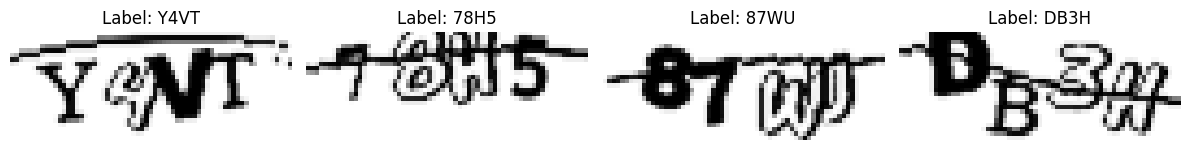

Total samples: 4000
Training samples: 3600
Validation samples: 400
Character set: 2345789ABCDEFHKLMNPRTUVWXYZ


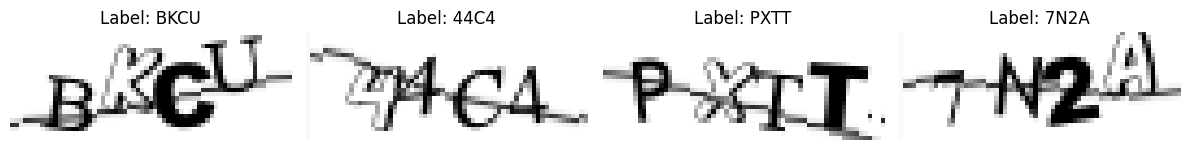

In [98]:
def visualize_dataset_samples(data_loader, idx_to_char, num_samples=16):
    """Visualize sample images from the dataset with their labels"""
    batch = next(iter(data_loader))
    images = batch['image']
    labels = batch['label']
    label_lengths = batch['label_length']

    # Calculate grid dimensions
    grid_size = min(num_samples, len(images))
    cols = 4
    rows = (grid_size + cols - 1) // cols

    plt.figure(figsize=(12, 3 * rows))

    for i in range(grid_size):
        plt.subplot(rows, cols, i + 1)

        # Convert tensor to numpy and display image
        img = images[i].squeeze().numpy()
        plt.imshow(img, cmap='gray')

        # Get the original text label
        label_length = label_lengths[i].item()
        text = get_text_from_indices(labels[i], idx_to_char, label_length)

        plt.title(f"Label: {text}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def plot_history(history, title=None):
    """Plot training history metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training and validation loss
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot validation accuracy
    ax2.plot(history['val_accuracy'])
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True)

    # Set a figure title if provided
    if title:
        fig.suptitle(title, fontsize=16)
        plt.subplots_adjust(top=0.85)  # Make room for the title

    plt.tight_layout()
    plt.show()


train_loader, val_loader, idx_to_char, max_length = load_and_prepare_data()
visualize_dataset_samples(train_loader, idx_to_char, num_samples=4)

base_train_loader, base_val_loader, base_idx_to_char, base_max_length = load_and_prepare_baseline_data()
visualize_dataset_samples(base_train_loader, base_idx_to_char, num_samples=4)

# Training the improved model

Total samples: 4000
Training samples: 3600
Validation samples: 400
Character set: 2345789ABCDEFHKLMNPRTUVWXYZ
Visualizing sample images from dataset:


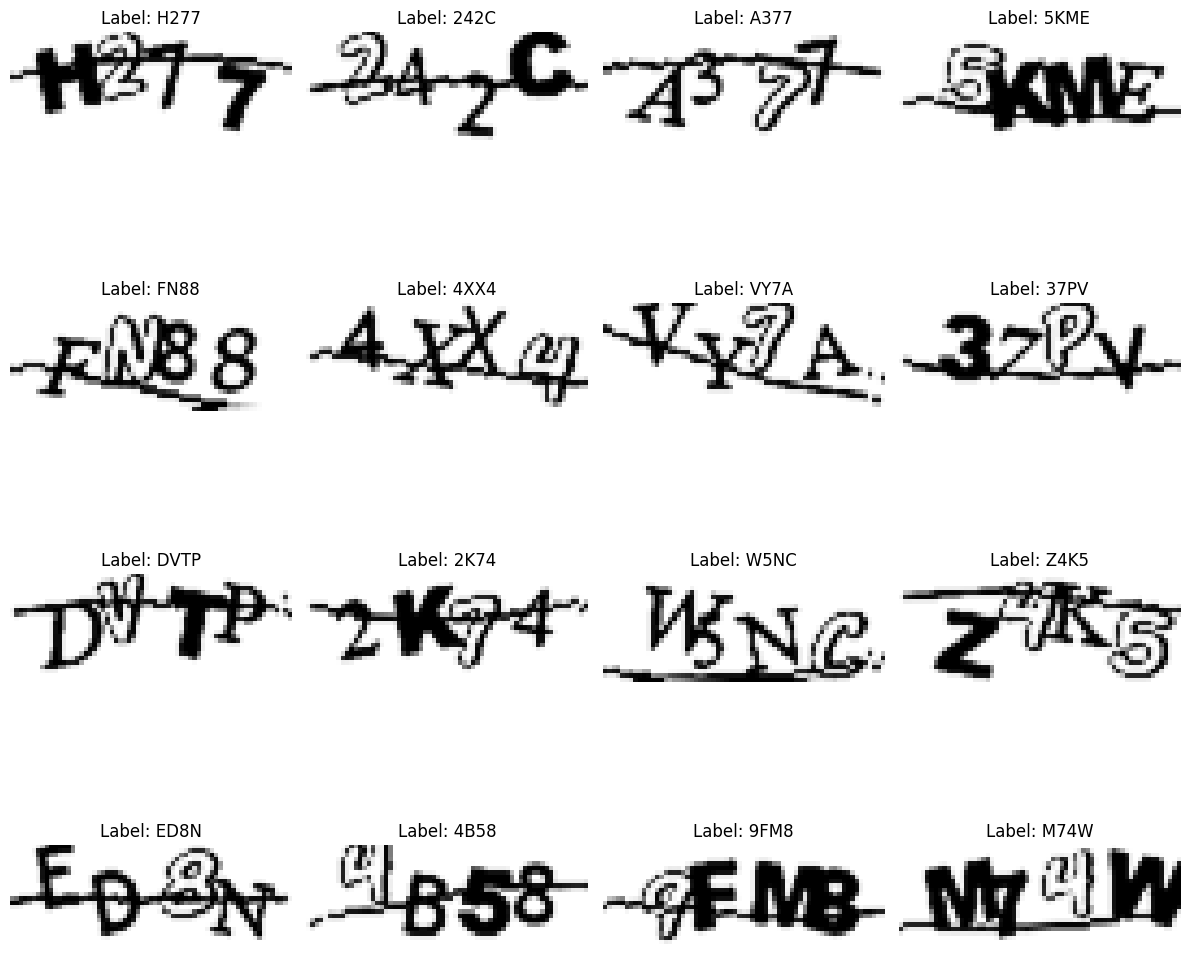

Model architecture:
ImprovedCaptchaModel(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.15, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, 

Epoch 1/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/45 - Train Loss: 3.9368, Val Loss: 3.7293, Validation Accuracy: 0.00% (0/400)


Epoch 2/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/45 - Train Loss: 3.5732, Val Loss: 3.7729, Validation Accuracy: 0.00% (0/400)


Epoch 3/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/45 - Train Loss: 3.3404, Val Loss: 3.4028, Validation Accuracy: 0.00% (0/400)


Epoch 4/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/45 - Train Loss: 3.1213, Val Loss: 3.1503, Validation Accuracy: 0.00% (0/400)


Epoch 5/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/45 - Train Loss: 2.7670, Val Loss: 2.6046, Validation Accuracy: 0.00% (0/400)


Epoch 6/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/45 - Train Loss: 2.3380, Val Loss: 2.6679, Validation Accuracy: 0.00% (0/400)


Epoch 7/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/45 - Train Loss: 1.9075, Val Loss: 2.5101, Validation Accuracy: 1.25% (5/400)


Epoch 8/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/45 - Train Loss: 1.4113, Val Loss: 1.2567, Validation Accuracy: 8.25% (33/400)


Epoch 9/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/45 - Train Loss: 1.0689, Val Loss: 0.9432, Validation Accuracy: 28.00% (112/400)


Epoch 10/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/45 - Train Loss: 0.7496, Val Loss: 0.6545, Validation Accuracy: 43.00% (172/400)


Epoch 11/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/45 - Train Loss: 0.5669, Val Loss: 0.5355, Validation Accuracy: 47.75% (191/400)


Epoch 12/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/45 - Train Loss: 0.4167, Val Loss: 0.3576, Validation Accuracy: 64.75% (259/400)


Epoch 13/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/45 - Train Loss: 0.3268, Val Loss: 0.3560, Validation Accuracy: 62.75% (251/400)


Epoch 14/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/45 - Train Loss: 0.2570, Val Loss: 0.2668, Validation Accuracy: 70.50% (282/400)


Epoch 15/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/45 - Train Loss: 0.1907, Val Loss: 0.1785, Validation Accuracy: 83.50% (334/400)


Epoch 16/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/45 - Train Loss: 0.1520, Val Loss: 0.2165, Validation Accuracy: 78.25% (313/400)


Epoch 17/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/45 - Train Loss: 0.1422, Val Loss: 0.1648, Validation Accuracy: 82.50% (330/400)


Epoch 18/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/45 - Train Loss: 0.1287, Val Loss: 0.1478, Validation Accuracy: 84.50% (338/400)


Epoch 19/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/45 - Train Loss: 0.1004, Val Loss: 0.1079, Validation Accuracy: 87.25% (349/400)


Epoch 20/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/45 - Train Loss: 0.0807, Val Loss: 0.1044, Validation Accuracy: 90.00% (360/400)


Epoch 21/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21/45 - Train Loss: 0.0642, Val Loss: 0.1247, Validation Accuracy: 86.50% (346/400)


Epoch 22/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22/45 - Train Loss: 0.0580, Val Loss: 0.0938, Validation Accuracy: 89.25% (357/400)


Epoch 23/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23/45 - Train Loss: 0.0562, Val Loss: 0.1085, Validation Accuracy: 87.00% (348/400)


Epoch 24/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24/45 - Train Loss: 0.0696, Val Loss: 0.1205, Validation Accuracy: 87.00% (348/400)


Epoch 25/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 25/45 - Train Loss: 0.0610, Val Loss: 0.1315, Validation Accuracy: 89.50% (358/400)


Epoch 26/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 26/45 - Train Loss: 0.0555, Val Loss: 0.1076, Validation Accuracy: 89.50% (358/400)


Epoch 27/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 27/45 - Train Loss: 0.0505, Val Loss: 0.1049, Validation Accuracy: 89.75% (359/400)


Epoch 28/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 28/45 - Train Loss: 0.0382, Val Loss: 0.0990, Validation Accuracy: 88.25% (353/400)


Epoch 29/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 29/45 - Train Loss: 0.0539, Val Loss: 0.1279, Validation Accuracy: 84.50% (338/400)


Epoch 30/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 30/45 - Train Loss: 0.0714, Val Loss: 0.1331, Validation Accuracy: 86.75% (347/400)


Epoch 31/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 31/45 - Train Loss: 0.0615, Val Loss: 0.1465, Validation Accuracy: 86.75% (347/400)


Epoch 32/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 32/45 - Train Loss: 0.0562, Val Loss: 0.1344, Validation Accuracy: 88.25% (353/400)


Epoch 33/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 33/45 - Train Loss: 0.0776, Val Loss: 0.0696, Validation Accuracy: 92.25% (369/400)


Epoch 34/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 34/45 - Train Loss: 0.0512, Val Loss: 0.0681, Validation Accuracy: 92.50% (370/400)


Epoch 35/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 35/45 - Train Loss: 0.0368, Val Loss: 0.0760, Validation Accuracy: 91.75% (367/400)


Epoch 36/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 36/45 - Train Loss: 0.0316, Val Loss: 0.0454, Validation Accuracy: 94.75% (379/400)


Epoch 37/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 37/45 - Train Loss: 0.0215, Val Loss: 0.0646, Validation Accuracy: 94.00% (376/400)


Epoch 38/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 38/45 - Train Loss: 0.0434, Val Loss: 0.0801, Validation Accuracy: 92.25% (369/400)


Epoch 39/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 39/45 - Train Loss: 0.0489, Val Loss: 0.0482, Validation Accuracy: 94.00% (376/400)


Epoch 40/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 40/45 - Train Loss: 0.0248, Val Loss: 0.0697, Validation Accuracy: 93.25% (373/400)


Epoch 41/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 41/45 - Train Loss: 0.0386, Val Loss: 0.0654, Validation Accuracy: 93.75% (375/400)


Epoch 42/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 42/45 - Train Loss: 0.0300, Val Loss: 0.0778, Validation Accuracy: 92.50% (370/400)


Epoch 43/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 43/45 - Train Loss: 0.0257, Val Loss: 0.0805, Validation Accuracy: 92.75% (371/400)


Epoch 44/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 44/45 - Train Loss: 0.0234, Val Loss: 0.0481, Validation Accuracy: 94.25% (377/400)


Epoch 45/45:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 45/45 - Train Loss: 0.0256, Val Loss: 0.0460, Validation Accuracy: 95.00% (380/400)
Model saved to captcha_model.pth


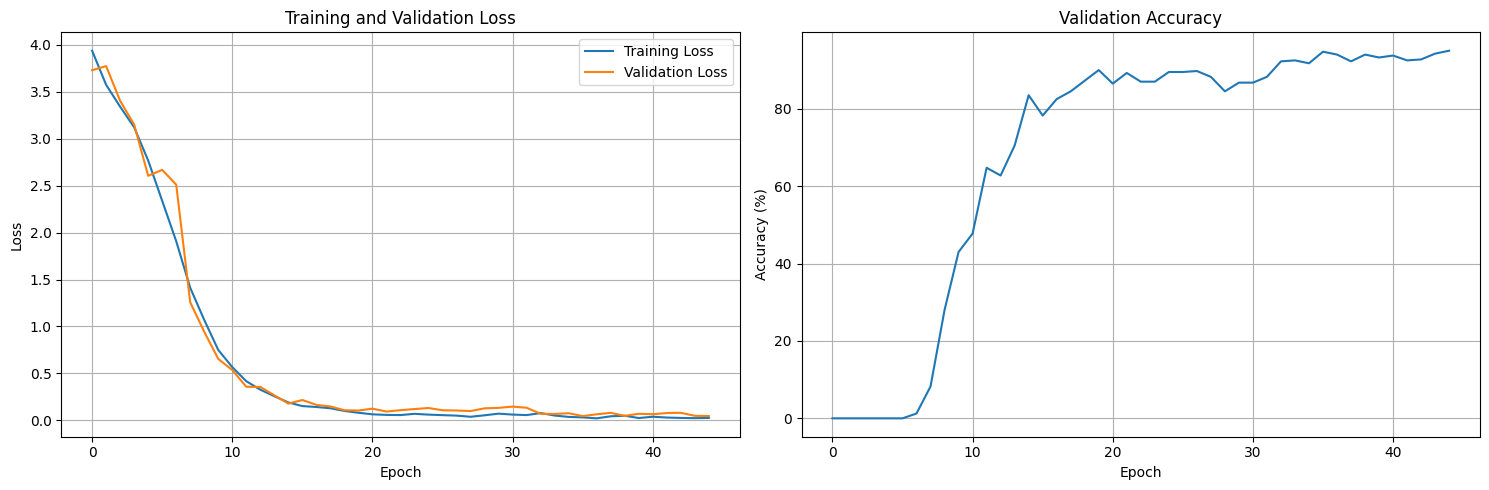

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Final accuracy: 95.00% (380/400)


In [45]:
def train_model(model, train_loader, val_loader, idx_to_char):
    """Train the model and track performance metrics"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=CONFIG.LEARNING_RATE)

    # CTC Loss for sequence labeling
    criterion = nn.CTCLoss(blank=BLANK_TOKEN, zero_infinity=True)

    # History tracking
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in range(CONFIG.NUM_EPOCHS):
        # Training phase
        model.train()
        train_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG.NUM_EPOCHS}"):
            images = batch['image'].to(device)
            labels = batch['label']
            label_lengths = batch['label_length']

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Prepare for CTC loss
            outputs_trans = outputs.transpose(0, 1)
            input_lengths = torch.full((outputs.size(0),), outputs.size(1), dtype=torch.long)

            # Calculate loss
            loss = criterion(outputs_trans, labels, input_lengths, label_lengths)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Average loss for the epoch
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        # Validation phase
        accuracy, val_loss, correct, total = evaluate_with_loss(
            model, val_loader, device, idx_to_char, criterion
        )
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(accuracy)

        # Log metrics
        print(f"Epoch {epoch+1}/{CONFIG.NUM_EPOCHS} - "
                  f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Validation Accuracy: {accuracy:.2f}% ({correct}/{total})")

    # Save final model
    torch.save(model.state_dict(), CONFIG.MODEL_SAVE_PATH)
    print(f"Model saved to {CONFIG.MODEL_SAVE_PATH}")

    return model, history

def main():
    try:
        # 1. Load and prepare data
        train_loader, val_loader, idx_to_char, max_length = load_and_prepare_data()

        # 2. Visualize sample images
        print("Visualizing sample images from dataset:")
        visualize_dataset_samples(train_loader, idx_to_char, num_samples=16)

        # 3. Create model
        num_chars = len(idx_to_char)
        model = ImprovedCaptchaModel(num_chars)

        print("Model architecture:")
        print(f"{model}")

        # 4. Train model
        model, history = train_model(model, train_loader, val_loader, idx_to_char)

        # 5. Plot training history
        plot_history(history)

        # 6. Final evaluation
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        accuracy, val_loss, correct, total = evaluate_with_loss(
            model, val_loader, device, idx_to_char, nn.CTCLoss(blank=BLANK_TOKEN)
        )
        print(f"Final accuracy: {accuracy:.2f}% ({correct}/{total})")

        return model, history

    except Exception as e:
        print(f"Error in main function: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    model, history = main()

# Training the baseline model

Total samples: 4000
Training samples: 3600
Validation samples: 400
Character set: 2345789ABCDEFHKLMNPRTUVWXYZ
Visualizing sample images from dataset:


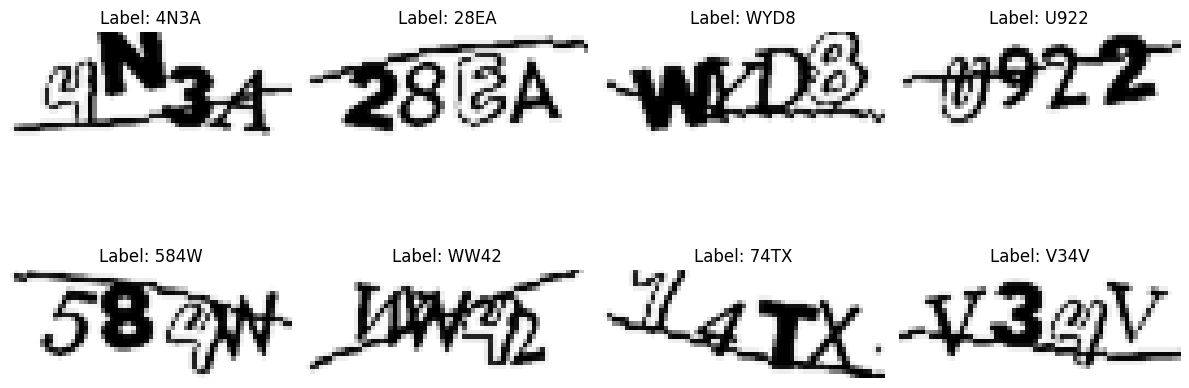

Baseline model architecture:
CaptchaModel(
  (cnn): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (reshape): Linear(in_features=144, out_features=48, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(48, 48, batch_first=True, bidirectional=True)
  (classifier): Linear(in_features=96, out_features=28, bias=True)
)
Using device: cuda


Epoch 1/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 4.3775, Val Loss: 3.6537, Validation Accuracy: 0.00% (0/400)


Epoch 2/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 3.6621, Val Loss: 3.6585, Validation Accuracy: 0.00% (0/400)


Epoch 3/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 3.6678, Val Loss: 3.6572, Validation Accuracy: 0.00% (0/400)


Epoch 4/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 3.6597, Val Loss: 3.6615, Validation Accuracy: 0.00% (0/400)


Epoch 5/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 3.6536, Val Loss: 3.6498, Validation Accuracy: 0.00% (0/400)


Epoch 6/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 3.6404, Val Loss: 3.6545, Validation Accuracy: 0.00% (0/400)


Epoch 7/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 3.6129, Val Loss: 3.6022, Validation Accuracy: 0.00% (0/400)


Epoch 8/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 3.5912, Val Loss: 3.6390, Validation Accuracy: 0.00% (0/400)


Epoch 9/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 3.5509, Val Loss: 4.0829, Validation Accuracy: 0.00% (0/400)


Epoch 10/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 3.4435, Val Loss: 3.7512, Validation Accuracy: 0.00% (0/400)


Epoch 11/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 3.2426, Val Loss: 3.9278, Validation Accuracy: 0.00% (0/400)


Epoch 12/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 2.9788, Val Loss: 3.0614, Validation Accuracy: 0.00% (0/400)


Epoch 13/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 2.7382, Val Loss: 3.2781, Validation Accuracy: 0.00% (0/400)


Epoch 14/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 2.4538, Val Loss: 2.6505, Validation Accuracy: 0.00% (0/400)


Epoch 15/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 2.1713, Val Loss: 1.9910, Validation Accuracy: 1.75% (7/400)


Epoch 16/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 1.8331, Val Loss: 2.6526, Validation Accuracy: 0.00% (0/400)


Epoch 17/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 1.6108, Val Loss: 1.4588, Validation Accuracy: 5.25% (21/400)


Epoch 18/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 1.3948, Val Loss: 1.8994, Validation Accuracy: 2.50% (10/400)


Epoch 19/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 1.2879, Val Loss: 1.5059, Validation Accuracy: 8.25% (33/400)


Epoch 20/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 1.1262, Val Loss: 1.0337, Validation Accuracy: 23.00% (92/400)


Epoch 21/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 1.0246, Val Loss: 0.9674, Validation Accuracy: 25.50% (102/400)


Epoch 22/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.9236, Val Loss: 1.1375, Validation Accuracy: 14.25% (57/400)


Epoch 23/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.8441, Val Loss: 0.9946, Validation Accuracy: 17.25% (69/400)


Epoch 24/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.7734, Val Loss: 0.9243, Validation Accuracy: 25.00% (100/400)


Epoch 25/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.6862, Val Loss: 1.7585, Validation Accuracy: 5.25% (21/400)


Epoch 26/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.6552, Val Loss: 0.6898, Validation Accuracy: 39.50% (158/400)


Epoch 27/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.5890, Val Loss: 0.8107, Validation Accuracy: 32.00% (128/400)


Epoch 28/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.5945, Val Loss: 0.5779, Validation Accuracy: 44.50% (178/400)


Epoch 29/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.5413, Val Loss: 0.5833, Validation Accuracy: 41.00% (164/400)


Epoch 30/30:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.4876, Val Loss: 0.5653, Validation Accuracy: 42.75% (171/400)
Baseline model saved to captcha_baseline_model.pth


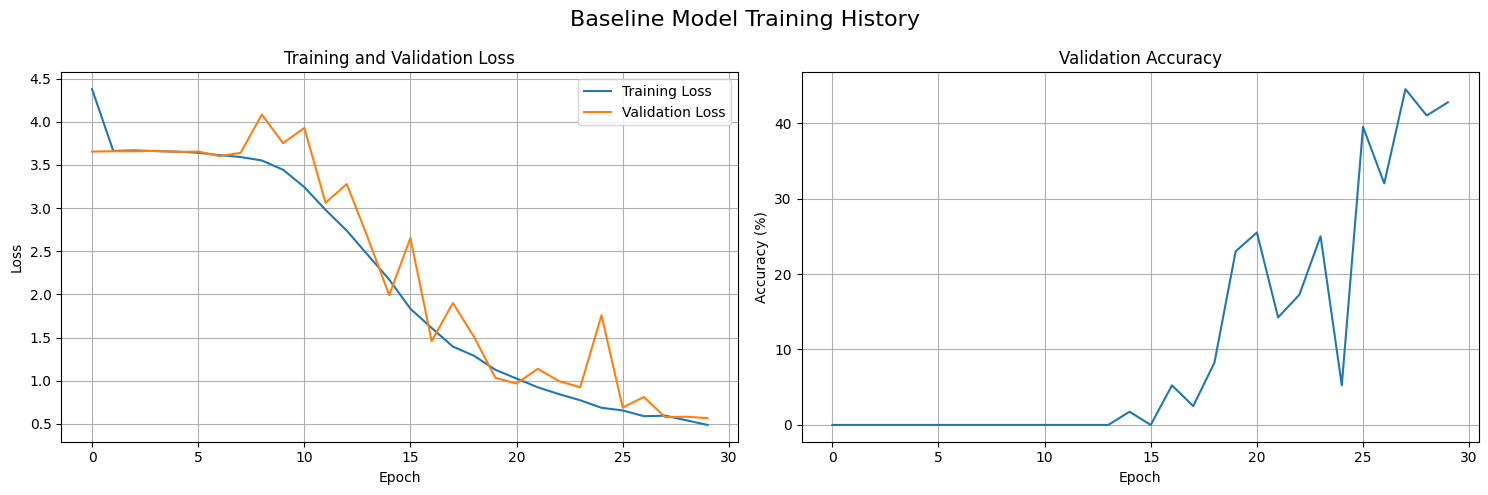

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Baseline model final accuracy: 42.75% (171/400)


In [99]:
def train_baseline_model(model, train_loader, val_loader, idx_to_char):
    """Train the model and track performance metrics"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    NUM_EPOCHS = 30  # Reduced epochs for baseline model

    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=CONFIG.LEARNING_RATE)

    # CTC Loss for sequence labeling
    criterion = nn.CTCLoss(blank=BLANK_TOKEN, zero_infinity=True)

    # History tracking
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in range(NUM_EPOCHS):
        # Training phase
        model.train()
        train_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
            images = batch['image'].to(device)
            labels = batch['label']
            label_lengths = batch['label_length']

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Prepare for CTC loss
            outputs_trans = outputs.transpose(0, 1)
            input_lengths = torch.full((outputs.size(0),), outputs.size(1), dtype=torch.long)

            # Calculate loss
            loss = criterion(outputs_trans, labels, input_lengths, label_lengths)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Average loss for the epoch
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        # Validation phase
        accuracy, val_loss, correct, total = evaluate_with_loss(
            model, val_loader, device, idx_to_char, criterion
        )
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(accuracy)

        # Log metrics
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} - "
                  f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Validation Accuracy: {accuracy:.2f}% ({correct}/{total})")

    # Save final model
    torch.save(model.state_dict(), CONFIG.BASELINE_MODEL_SAVE_PATH)
    print(f"Baseline model saved to {CONFIG.BASELINE_MODEL_SAVE_PATH}")

    return model, history

def run_baseline():
    try:
        # 1. Load and prepare data
        train_loader, val_loader, idx_to_char, max_length = load_and_prepare_data()

        # 2. Visualize sample images
        print("Visualizing sample images from dataset:")
        visualize_dataset_samples(train_loader, idx_to_char, num_samples=8)

        # 3. Create baseline model
        num_chars = len(idx_to_char)
        model = CaptchaModel(num_chars)

        print("Baseline model architecture:")
        print(f"{model}")

        # 4. Train baseline model
        model, history = train_baseline_model(model, train_loader, val_loader, idx_to_char)

        # 5. Plot training history
        plot_history(history, title="Baseline Model Training History")

        # 6. Final evaluation
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        accuracy, val_loss, correct, total = evaluate_with_loss(
            model, val_loader, device, idx_to_char, nn.CTCLoss(blank=BLANK_TOKEN)
        )
        print(f"Baseline model final accuracy: {accuracy:.2f}% ({correct}/{total})")

        return model, history

    except Exception as e:
        print(f"Error in baseline function: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    baseline_model, baseline_history = run_baseline()

# Testing the models

After training, we'll create a separate test dataset to evaluate how well our models generalize to unseen data.

In [128]:
def create_test_dataset(test_ratio=0.2):
    """Create a test dataset separate from training and validation sets"""
    # Get all PNG files
    if os.path.isdir(CONFIG.TARGET_FOLDER):
        all_images = [os.path.join(CONFIG.TARGET_FOLDER, f)
                    for f in os.listdir(CONFIG.TARGET_FOLDER)
                    if f.lower().endswith('.png')]
    else:
        all_images = [f for f in png_files if f.lower().endswith('.png')]
    
    if not all_images:
        raise FileNotFoundError(f"No images found in {CONFIG.TARGET_FOLDER}")
    
    # Set random seed for reproducibility
    np.random.seed(CONFIG.RANDOM_SEED + 25)  # Different seed than training
    np.random.shuffle(all_images)
    
    # Calculate number of test samples (using a different approach than training/val split)
    num_samples = min(CONFIG.MAX_SAMPLES, len(all_images)) if CONFIG.MAX_SAMPLES else len(all_images)
    num_test = int(num_samples * test_ratio)
    
    # Take samples from the end to avoid overlap with training/validation
    test_images = all_images[-num_test:]
    
    # Extract labels from filenames
    test_labels = [os.path.splitext(os.path.basename(img))[0] for img in test_images]
    
    # Create character mappings (use the same mapping as in training)
    char_img = sorted(list(set(char for label in test_labels for char in label)))
    char_to_idx = {char: idx+1 for idx, char in enumerate(char_img)}
    idx_to_char = {idx+1: char for idx, char in enumerate(char_img)}
    
    # Find maximum label length for padding
    max_length = max(len(label) for label in test_labels)
    
    # Create preprocessor (same as for training)
    preprocessor = Preprocessor(
        upscale_factor=2.0,
        upscale_method='lanczos',
        contrast_factor=4,
        brightness_factor=1.1,
        sharpen_after_upscale=True,
        sharpen_amount=2.3,
        sharpen_blend=0.8,
        edge_enhancement=True
    )
    
    # Create image transforms
    transform = transforms.Compose([
        transforms.Lambda(lambda img: preprocessor.preprocess(img)),
        transforms.Resize((CONFIG.IMG_HEIGHT, CONFIG.IMG_WIDTH)),
        transforms.ToTensor(),
    ])
    
    # Create dataset
    test_dataset = CaptchaDataset(test_images, test_labels, char_to_idx, max_length, transform)
    
    # Create dataloader
    test_loader = DataLoader(test_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False)
    
    print(f"Test dataset created with {len(test_images)} samples")
    return test_loader, idx_to_char, max_length, test_images

In [129]:
def test_model(model_path=None, model_type="improved"):
    """Test the trained model on a separate test dataset"""
    # Create test dataset
    test_loader, idx_to_char, max_length, test_images = create_test_dataset(CONFIG.TEST_RATIO)
    
    # Load the model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_chars = len(idx_to_char)
    
    # Create appropriate model based on model_type
    if model_type.lower() == "baseline":
        model = CaptchaModel(num_chars)
        default_path = CONFIG.BASELINE_MODEL_SAVE_PATH
    else:  # improved model is default
        model = ImprovedCaptchaModel(num_chars)
        default_path = CONFIG.MODEL_SAVE_PATH
    
    # Load saved model weights if path provided
    if model_path:
        model.load_state_dict(torch.load(model_path, map_location=device))
    else:
        model.load_state_dict(torch.load(default_path, map_location=device))
    
    model = model.to(device)
    model.eval()
    
    # Evaluate model on test dataset
    criterion = nn.CTCLoss(blank=BLANK_TOKEN, zero_infinity=True)
    accuracy, test_loss, correct, total = evaluate_with_loss(
        model, test_loader, device, idx_to_char, criterion
    )
    
    model_name = "Baseline" if model_type.lower() == "baseline" else "Improved"
    print(f"{model_name} Model Test Results:")
    print(f"Accuracy: {accuracy:.2f}% ({correct}/{total})")
    print(f"Loss: {test_loss:.4f}")
    
    return model, test_loader, idx_to_char, accuracy, test_loss

In [130]:
def compare_models():
    """Test and compare both baseline and improved models on the same test dataset"""
    print("Comparing baseline and improved models on the same test dataset...\n")
    
    # Test baseline model
    print("=== Testing Baseline Model ===")
    baseline_model, test_loader, idx_to_char, baseline_accuracy, baseline_loss = test_model(
        model_type="baseline"
    )
    
    # Test improved model
    print("\n=== Testing Improved Model ===")
    improved_model, _, _, improved_accuracy, improved_loss = test_model(
        model_type="improved"
    )
    
    # Calculate improvement
    accuracy_improvement = improved_accuracy - baseline_accuracy
    loss_improvement = baseline_loss - improved_loss
    
    # Display comparison
    print("\n=== Model Comparison ===")
    print(f"{'Model':<15} {'Accuracy':<15} {'Loss':<10}")
    print("-" * 40)
    print(f"{'Baseline':<15} {baseline_accuracy:.2f}%{'':<10} {baseline_loss:.4f}")
    print(f"{'Improved':<15} {improved_accuracy:.2f}%{'':<10} {improved_loss:.4f}")
    print("-" * 40)
    print(f"{'Improvement':<15} {accuracy_improvement:.2f}%{'':<10} {loss_improvement:.4f}")
    
    # Visualize both model results
    return baseline_model, improved_model, test_loader, idx_to_char

In [131]:
def visualize_model_comparison(baseline_model, improved_model, test_loader, idx_to_char, num_samples=10):
    """Visualize and compare predictions from both models on the same test samples"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    baseline_model.eval()
    improved_model.eval()
    
    # Get a batch of test data
    batch = next(iter(test_loader))
    images = batch['image'].to(device)
    labels = batch['label']
    label_lengths = batch['label_length']
    
    # Get true text labels
    true_labels = []
    for i, label in enumerate(labels):
        label_length = label_lengths[i].item()
        text = get_text_from_indices(label, idx_to_char, label_length)
        true_labels.append(text)
    
    # Get predictions from both models
    with torch.no_grad():
        baseline_outputs = baseline_model(images)
        baseline_predictions = decode_predictions(baseline_outputs, idx_to_char)
        
        improved_outputs = improved_model(images)
        improved_predictions = decode_predictions(improved_outputs, idx_to_char)
    
    # Visualize comparison for a subset of the samples
    n = min(num_samples, len(images))
    fig, axes = plt.subplots(n, 3, figsize=(15, n * 3))
    
    if n == 1:  # Handle case of a single sample
        axes = axes.reshape(1, 3)
    
    for i in range(n):
        # Original image
        axes[i, 0].imshow(images[i].cpu().squeeze(), cmap='gray')
        axes[i, 0].set_title(f"True: {true_labels[i]}")
        axes[i, 0].axis('off')
        
        # Baseline model prediction
        baseline_correct = baseline_predictions[i] == true_labels[i]
        color = 'green' if baseline_correct else 'red'
        axes[i, 1].imshow(images[i].cpu().squeeze(), cmap='gray')
        axes[i, 1].set_title(f"Baseline: {baseline_predictions[i]}", color=color)
        axes[i, 1].axis('off')
        
        # Improved model prediction
        improved_correct = improved_predictions[i] == true_labels[i]
        color = 'green' if improved_correct else 'red'
        axes[i, 2].imshow(images[i].cpu().squeeze(), cmap='gray')
        axes[i, 2].set_title(f"Improved: {improved_predictions[i]}", color=color)
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display statistics
    baseline_correct = sum(1 for true, pred in zip(true_labels, baseline_predictions) if true == pred)
    improved_correct = sum(1 for true, pred in zip(true_labels, improved_predictions) if true == pred)
    
    print(f"Sample Results (n={len(true_labels)}):")
    print(f"Baseline Accuracy: {baseline_correct/len(true_labels)*100:.2f}% ({baseline_correct}/{len(true_labels)})")
    print(f"Improved Accuracy: {improved_correct/len(true_labels)*100:.2f}% ({improved_correct}/{len(true_labels)})")
    
    # Show interesting cases where one model succeeds and the other fails
    baseline_only = [(i, true_labels[i], baseline_predictions[i], improved_predictions[i]) 
                     for i in range(len(true_labels)) 
                     if baseline_predictions[i] == true_labels[i] and improved_predictions[i] != true_labels[i]]
    
    improved_only = [(i, true_labels[i], baseline_predictions[i], improved_predictions[i]) 
                     for i in range(len(true_labels)) 
                     if baseline_predictions[i] != true_labels[i] and improved_predictions[i] == true_labels[i]]
    
    if baseline_only:
        print("\n3 Cases where only baseline model was correct:")
        for i, true, base_pred, imp_pred in baseline_only[:3]:  # Show up to 3 examples
            print(f"Sample {i}: True={true}, Baseline={base_pred}, Improved={imp_pred}")
    
    if improved_only:
        print("\n3 Cases where only improved model was correct:")
        for i, true, base_pred, imp_pred in improved_only[:3]:  # Show up to 3 examples
            print(f"Sample {i}: True={true}, Baseline={base_pred}, Improved={imp_pred}")

In [132]:
def visualize_test_results(model, test_loader, idx_to_char, num_samples=16):
    """Visualize model predictions on test samples"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    # Collect sample images, true labels, and predictions
    all_images = []
    all_true_labels = []
    all_predictions = []
    all_correct = []
    
    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            labels = batch['label']
            label_lengths = batch['label_length']
            
            # Get model predictions
            outputs = model(images)
            predictions = decode_predictions(outputs, idx_to_char)
            
            # Get true text labels
            true_texts = []
            for i, label in enumerate(labels):
                label_length = label_lengths[i].item()
                text = get_text_from_indices(label, idx_to_char, label_length)
                true_texts.append(text)
            
            # Determine if predictions are correct
            correct = [pred == true for pred, true in zip(predictions, true_texts)]
            
            # Collect results
            all_images.extend(images.cpu())
            all_true_labels.extend(true_texts)
            all_predictions.extend(predictions)
            all_correct.extend(correct)
            
            if len(all_images) >= num_samples * 2:  # Get more than needed to ensure we have enough of each type
                break
    
    # Separate correct and incorrect predictions
    correct_indices = [i for i, correct in enumerate(all_correct) if correct]
    incorrect_indices = [i for i, correct in enumerate(all_correct) if not correct]
    
    # Select samples to visualize (half correct, half incorrect if possible)
    num_correct = min(num_samples // 2, len(correct_indices))
    num_incorrect = min(num_samples - num_correct, len(incorrect_indices))
    
    # If we don't have enough of one type, take more of the other
    if num_correct < num_samples // 2 and len(incorrect_indices) > num_incorrect:
        num_incorrect = min(num_samples - num_correct, len(incorrect_indices))
    elif num_incorrect < num_samples - num_samples // 2 and len(correct_indices) > num_correct:
        num_correct = min(num_samples - num_incorrect, len(correct_indices))
    
    selected_correct = np.random.choice(correct_indices, num_correct, replace=False) if num_correct > 0 else []
    selected_incorrect = np.random.choice(incorrect_indices, num_incorrect, replace=False) if num_incorrect > 0 else []
    selected_indices = list(selected_correct) + list(selected_incorrect)
    
    # Visualize selected samples
    cols = 4
    rows = (len(selected_indices) + cols - 1) // cols
    
    plt.figure(figsize=(15, 3 * rows))
    for i, idx in enumerate(selected_indices):
        plt.subplot(rows, cols, i + 1)
        
        # Display image
        img = all_images[idx].squeeze().numpy()
        plt.imshow(img, cmap='gray')
        
        # Display true label and prediction
        true_label = all_true_labels[idx]
        pred = all_predictions[idx]
        is_correct = all_correct[idx]
        
        title = f"True: {true_label}\nPred: {pred}"
        title_color = 'green' if is_correct else 'red'
        
        plt.title(title, color=title_color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print overall statistics
    total_correct = sum(all_correct)
    accuracy = (total_correct / len(all_correct)) * 100
    print(f"Visualized {len(selected_indices)} test samples (out of {len(all_correct)} total)")
    print(f"Test Accuracy: {accuracy:.2f}% ({total_correct}/{len(all_correct)})")

=== Comparing Baseline and Improved Models ===
Comparing baseline and improved models on the same test dataset...

=== Testing Baseline Model ===
Test dataset created with 800 samples


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Baseline Model Test Results:
Accuracy: 54.00% (432/800)
Loss: 0.4650

=== Testing Improved Model ===
Test dataset created with 800 samples


c:\Python312\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Improved Model Test Results:
Accuracy: 96.25% (770/800)
Loss: 0.0282

=== Model Comparison ===
Model           Accuracy        Loss      
----------------------------------------
Baseline        54.00%           0.4650
Improved        96.25%           0.0282
----------------------------------------
Improvement     42.25%           0.4368

=== Visualizing Model Comparison ===


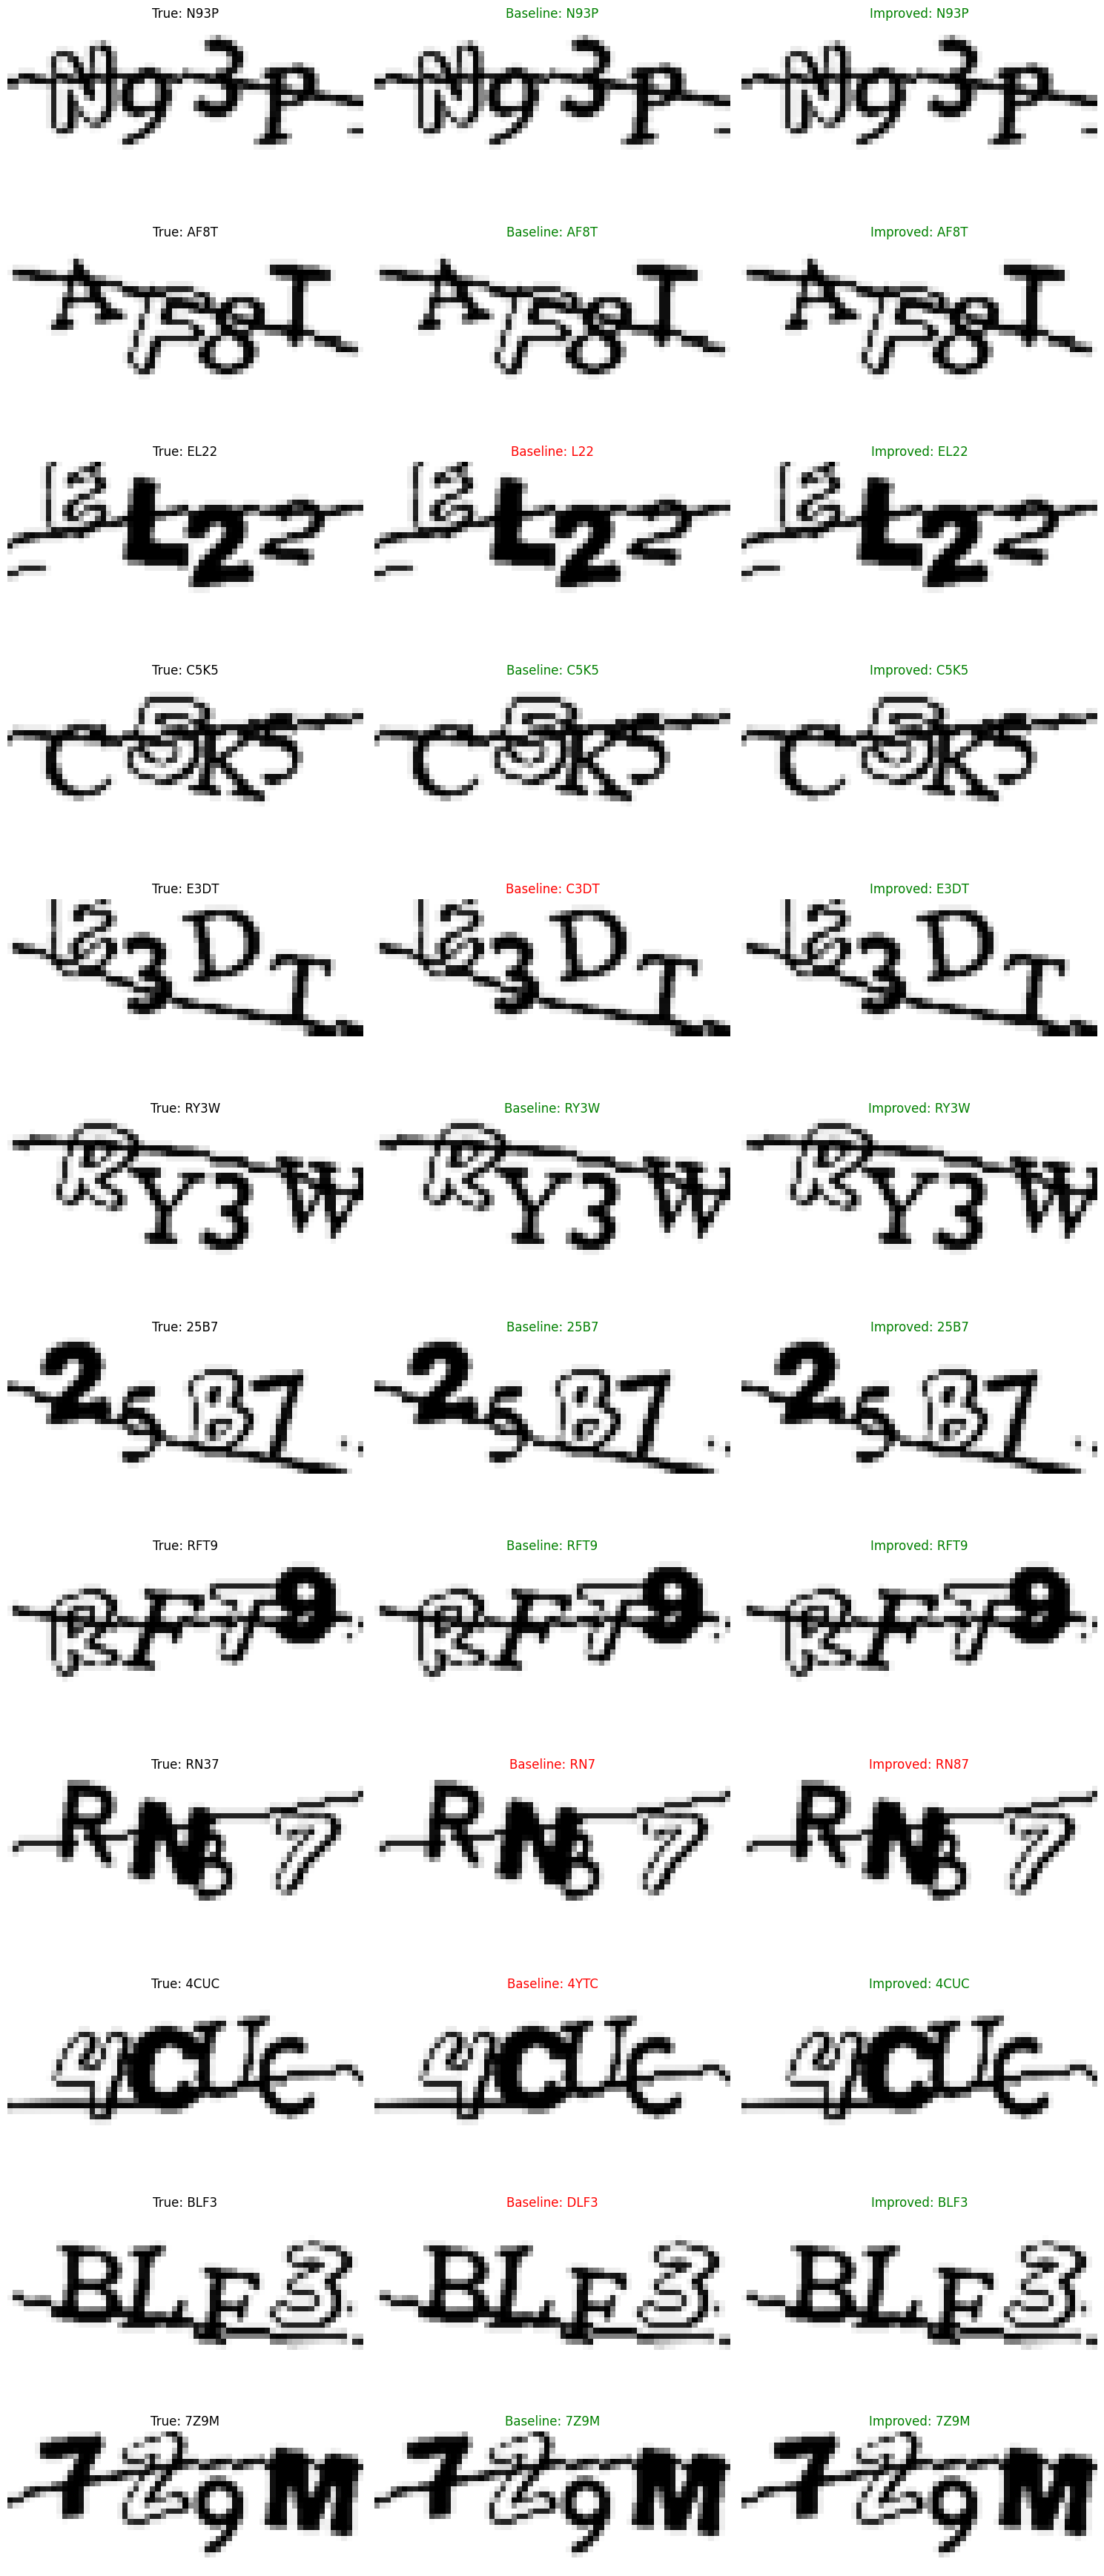

Sample Results (n=64):
Baseline Accuracy: 50.00% (32/64)
Improved Accuracy: 95.31% (61/64)

3 Cases where only improved model was correct:
Sample 2: True=EL22, Baseline=L22, Improved=EL22
Sample 4: True=E3DT, Baseline=C3DT, Improved=E3DT
Sample 9: True=4CUC, Baseline=4YTC, Improved=4CUC

=== Detailed Analysis of Improved Model ===


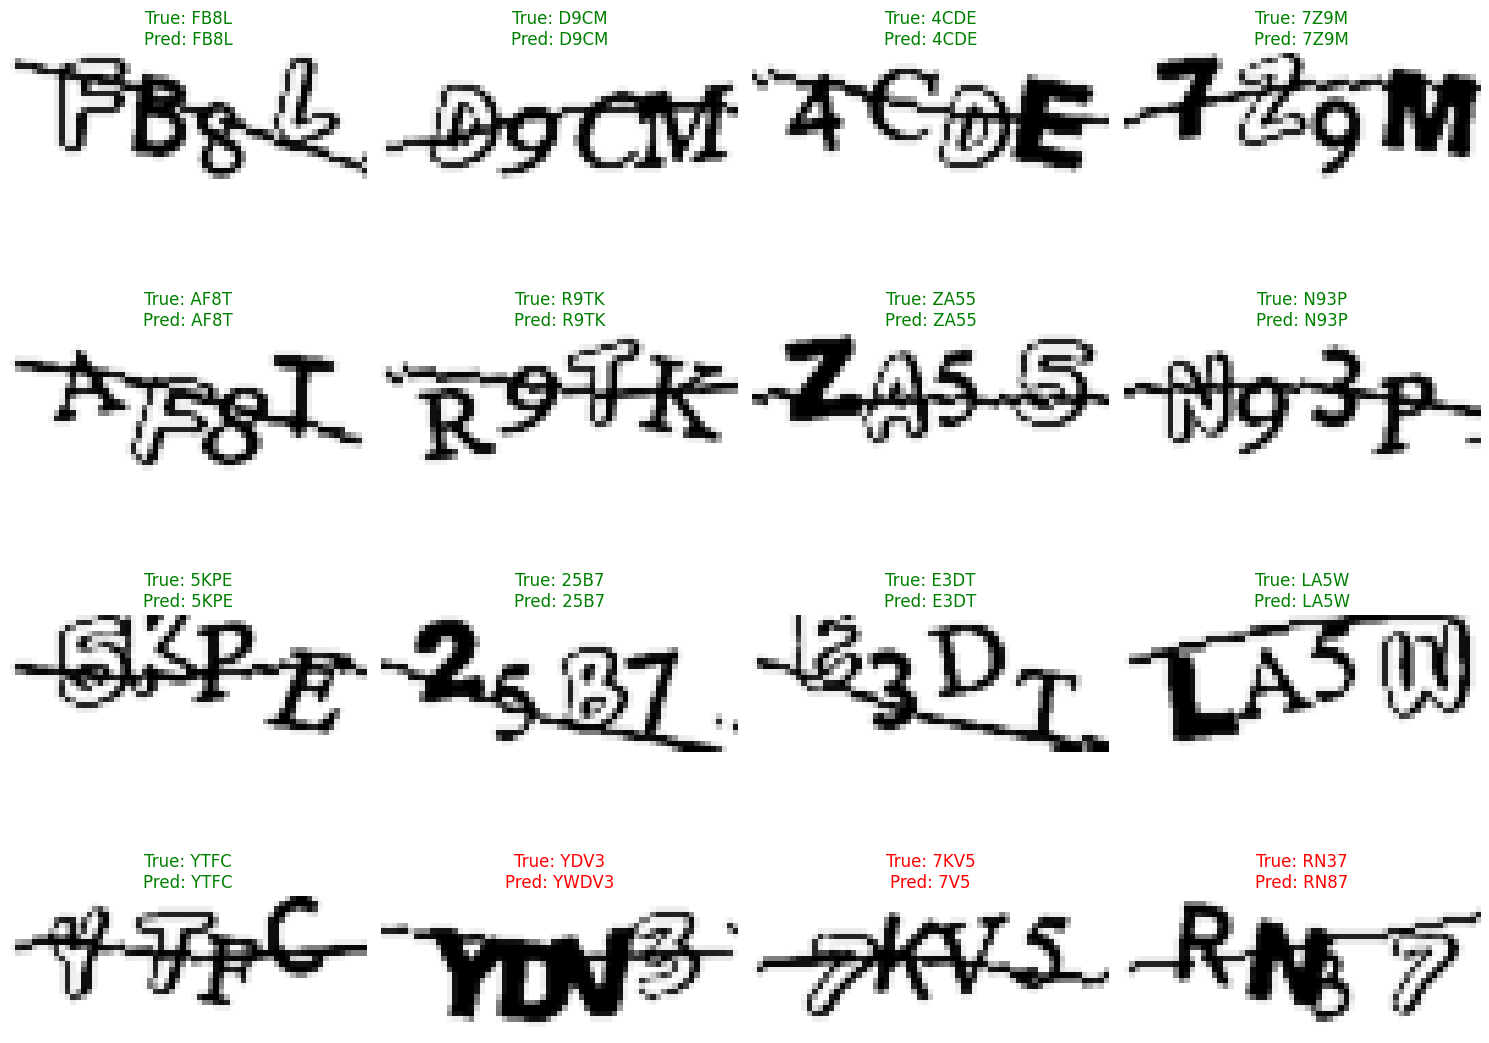

Visualized 16 test samples (out of 64 total)
Test Accuracy: 95.31% (61/64)

Test suite completed!


In [133]:
def run_full_test_suite():
    """Run a comprehensive test of both baseline and improved models"""
    # 1. Compare both models
    print("=== Comparing Baseline and Improved Models ===")
    baseline_model, improved_model, test_loader, idx_to_char = compare_models()
    
    # 2. Visualize comparison of both models
    print("\n=== Visualizing Model Comparison ===")
    visualize_model_comparison(baseline_model, improved_model, test_loader, idx_to_char, num_samples=12)
    
    # 3. Detailed visualization of improved model results
    print("\n=== Detailed Analysis of Improved Model ===")
    visualize_test_results(improved_model, test_loader, idx_to_char, num_samples=16)
    
    print("\nTest suite completed!")
    return improved_model, test_loader, idx_to_char

# Run the full test suite with both models
model, test_loader, idx_to_char = run_full_test_suite()

# Optional: Save the test results
# import datetime
# timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'idx_to_char': idx_to_char,
#     'config': CONFIG.__dict__
# }, f'captcha_model_test_{timestamp}.pth')
# print(f"Test results saved to captcha_model_test_{timestamp}.pth")